In [22]:
# Really simple

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [23]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [24]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [25]:
# Calculare pearson matrices

train_rest_p = np.stack([np.corrcoef(sub) for sub in train_rest_ts])
train_nback_p = np.stack([np.corrcoef(sub) for sub in train_nback_ts])

test_rest_p = np.stack([np.corrcoef(sub) for sub in test_rest_ts])
test_nback_p = np.stack([np.corrcoef(sub) for sub in test_nback_ts])

print(train_rest_p[0].shape)
print('Complete')

(264, 264)
Complete


In [26]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [27]:
# Convert to torch

import torch

train_rest_p_torch = torch.from_numpy(train_rest_p).float()
train_nback_p_torch = torch.from_numpy(train_nback_p).float()

test_rest_p_torch = torch.from_numpy(test_rest_p).float()
test_nback_p_torch = torch.from_numpy(test_nback_p).float()

X_train_torch = torch.from_numpy(X_train[:,0:1]).float()
X_test_torch = torch.from_numpy(X_test[:,0:1]).float()

print(test_nback_p_torch.shape)
print('Complete')

torch.Size([156, 264, 264])
Complete


In [28]:
def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

In [52]:
def modelEdges(ps1, ps2, p1=None, p2=None):
    Nsub = ps1.shape[0]
    
    if p1 is not None:
        ps1 = torch.cat([p1.unsqueeze(0), ps1])
        ps2 = torch.cat([p2.unsqueeze(0), ps2])
        Nsub += 1
    
    e1 = torch.einsum('aij,bij->ab',ps1,ps1)
#     e2 = torch.einsum('aij,bij->ab',ps2,ps2)
#     e3 = torch.einsum('aij,bij->ab',ps1,ps2)
    
    e1 = normalize(e1)
#     e2 = normalize(e2)
#     e3 = normalize(e3)
    
#     edges = torch.stack([e1],dim=2)
    
    return e1

def modelTrain(edges, feat, idx):
    Nsub = feat.shape[0]
    Nfeat = feat.shape[1]
    
    ageSav = feat[idx,0].detach().clone()
    feat[idx,0] = 0
    
#     edges = edges[:,:,0]
    
    # Layer 1
    a = torch.einsum('ab,bf->af',edges,feat)

    # Layer 2-4
    b = torch.einsum('ab,af->af',edges,a).reshape(Nsub,Nfeat)
    c = torch.einsum('ab,af->af',edges,b).reshape(Nsub,Nfeat)
    d = torch.einsum('ab,af->af',edges,c).reshape(Nsub,Nfeat)

    res = [a,b,c,d]
    h = torch.cat(res,dim=1).reshape(Nsub,-1)
    
    feat[idx,0] = ageSav
    
    return h[idx]

def modelTest(edges, f, feat):
    feat = torch.cat([f.unsqueeze(0), feat])
    
    return modelTrain(edges, feat, 0)

print('Complete')

Complete


In [54]:
e = modelEdges(train_rest_p_torch, train_nback_p_torch)
print(e[0:5,0:5])
h = []
for i in range(X_train_torch.shape[0]):
    h.append(modelTrain(e, X_train_torch, i).detach().numpy())
h = np.vstack(h)
print('Finished model...')

hp = np.hstack([h, train_rest_p.reshape(-1,264*264)])

# l2 = 0.005

# w, r, _, _ = np.linalg.lstsq(h.T@h + l2*np.eye(h.shape[1]), h.T@X_train[:,0], rcond=None)
w, r, _, _ = np.linalg.lstsq(hp, X_train[:,0], rcond=None)

print(r)
print('Complete')

tensor([[0.0040, 0.0019, 0.0038, 0.0033, 0.0023],
        [0.0019, 0.0033, 0.0020, 0.0018, 0.0015],
        [0.0038, 0.0020, 0.0044, 0.0034, 0.0025],
        [0.0033, 0.0018, 0.0034, 0.0035, 0.0022],
        [0.0023, 0.0015, 0.0025, 0.0022, 0.0030]])
Finished model...
[]
Complete


In [55]:
print(X_train_torch[0,0])
h = modelTrain(e, X_train_torch,0)
hp = np.hstack([h, train_rest_p[0].flatten()])
print(hp@w)

tensor(0.)
146.00000000000117


In [56]:
import matplotlib.pyplot as plt

y = X_train[:,0]
e = modelEdges(train_rest_p_torch, train_nback_p_torch)
h = []
for i in range(X_train_torch.shape[0]):
    if i % 10 == 0:
        print(i, end=' ')
    h.append(modelTrain(e, X_train_torch, i).detach().numpy())
    print(h[-1])
    if i == 10:
        raise Exception('Bad')
h = np.vstack(h)
yPred = h@w

# y = X_test[:,0]
# h = []
# for i in range(X_test.shape[0]):
#     if i % 10 == 0:
#         print(i, end=' ')
#     e = modelEdges(train_rest_p_torch, train_nback_p_torch, 
#                    test_nback_p_torch[i], test_nback_p_torch[i])
#     h.append(modelTest(e, X_test_torch[i,:], X_train_torch).detach().numpy())
#     print(h[-1])
#     if i == 10:
#         raise Exception('Bad')
# h = np.vstack(h)
# hp = np.hstack([h, test_rest_p.reshape(-1,264*264)])
# yPred = hp@w
# print()

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

0 [221.78363 276.21063 343.99432 428.41254]
[135.80547  103.1213    78.3032    59.458046]
[232.48813 304.21307 398.06592 520.8733 ]
[202.73163 230.79778 262.7494  299.1244 ]
[155.61365 135.65804 118.26149 103.09585]
[194.2916  213.27525 234.11374 256.9883 ]
[131.72957   97.134     71.624115  52.81378 ]
[120.22346   80.567345  53.991936  36.182514]
[149.83289 125.53091 105.17056  88.11254]
[173.31725 168.45221 163.72374 159.128  ]
10 [188.80307 199.96373 211.78412 224.30324]


Exception: Bad

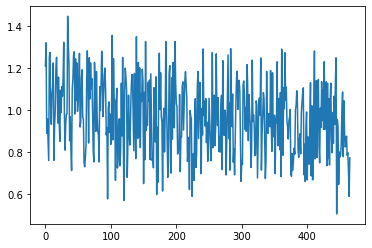

In [51]:
e = modelEdges(train_rest_p_torch, train_nback_p_torch)
y = X_train[:,0]
s = torch.sum(e, dim=1)
idcs = np.argsort(y)
s = s[idcs]

plt.plot(s)
plt.show()